# feature extraction and detection

In [1]:
# Install OpenCV if not already installed
!pip install opencv-python


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display images
def display_image(image, title='Image', size=(10, 8)):
    plt.figure(figsize=size)
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

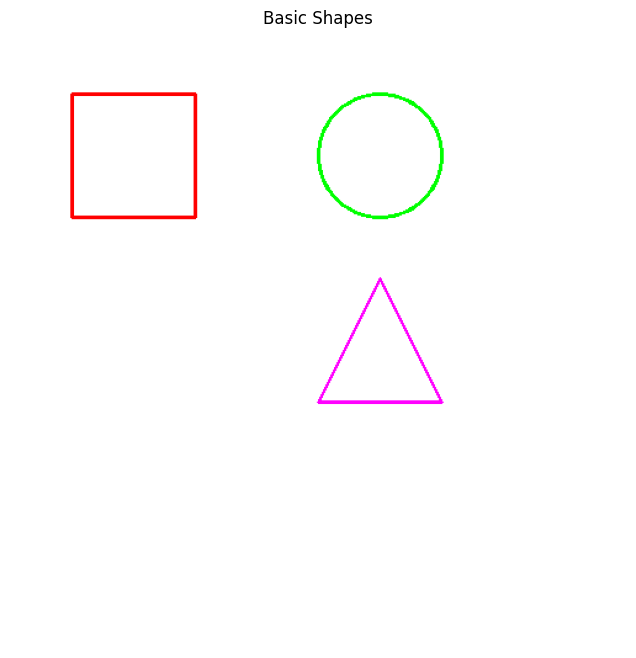

In [ ]:

#############################################
# PART 1: BASIC SHAPE DETECTION
#############################################

def basic_shape_detection():
    # Create a blank image
    img = np.zeros((500, 500, 3), dtype=np.uint8)
    img.fill(255)  # Fill with white

    # Draw shapes
    cv2.rectangle(img, (50, 50), (150, 150), (0, 0, 255), 2)  # Red rectangle
    cv2.circle(img, (300, 100), 50, (0, 255, 0), 2)  # Green circle
    #cv2.line(img, (100, 300), (400, 300), (255, 0, 0), 2)  # Blue line
    triangle_pts = np.array([[300, 200], [250, 300], [350, 300]], np.int32)
    cv2.polylines(img, [triangle_pts], True, (255, 0, 255), 2)  # Purple triangle
    cv2.imwrite('basic_shapes.png', img)
    display_image(img, "Basic Shapes")
    return img

basic_img = basic_shape_detection()

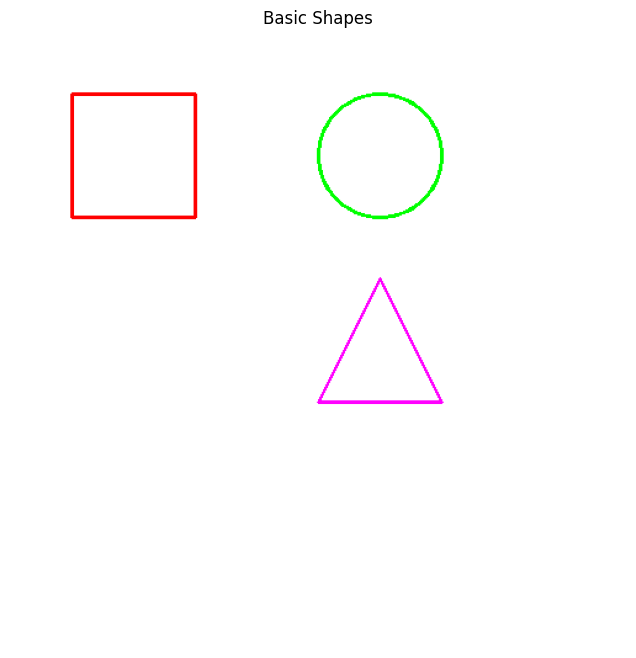

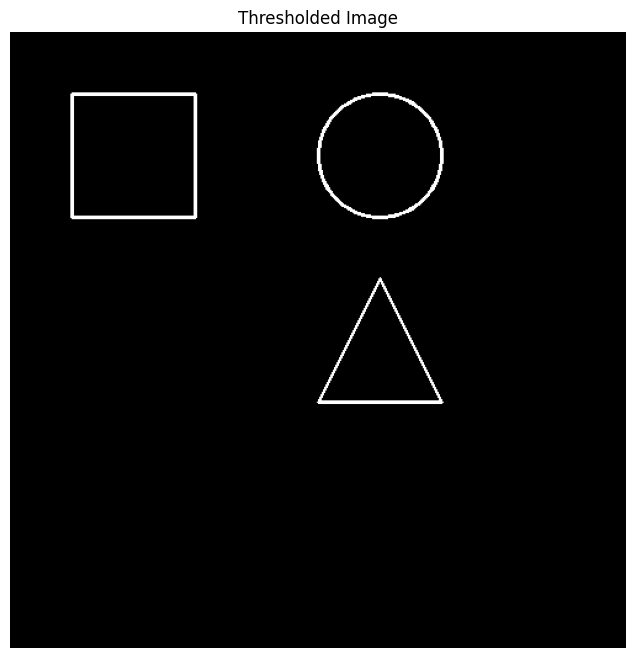

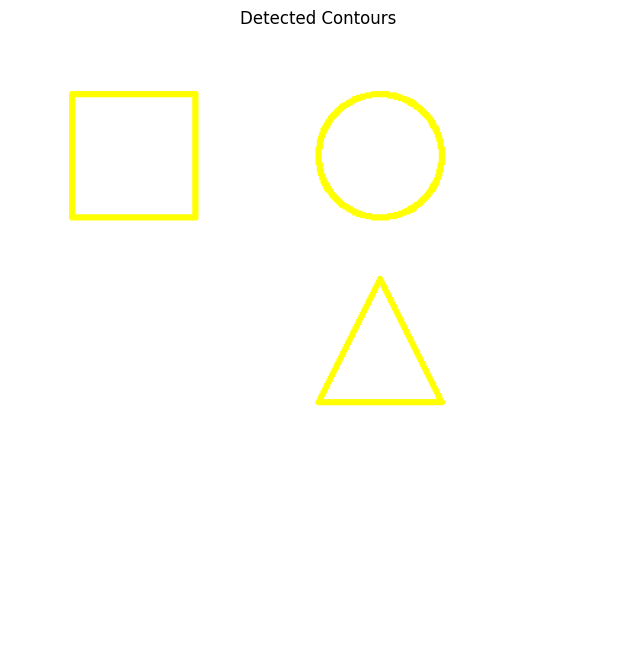

In [ ]:

#############################################
# PART 2: CONTOUR DETECTION
#############################################

def contour_detection(image_path=None):
    if image_path:
        # Load an image
        img = cv2.imread(image_path)
    else:
        # Use our shapes image
        img = basic_shape_detection()

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply threshold
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw all contours
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0, 255, 255), 2)

    display_image(thresh, "Thresholded Image")
    display_image(img_contours, "Detected Contours")

    return img, contours
img, contours = contour_detection()

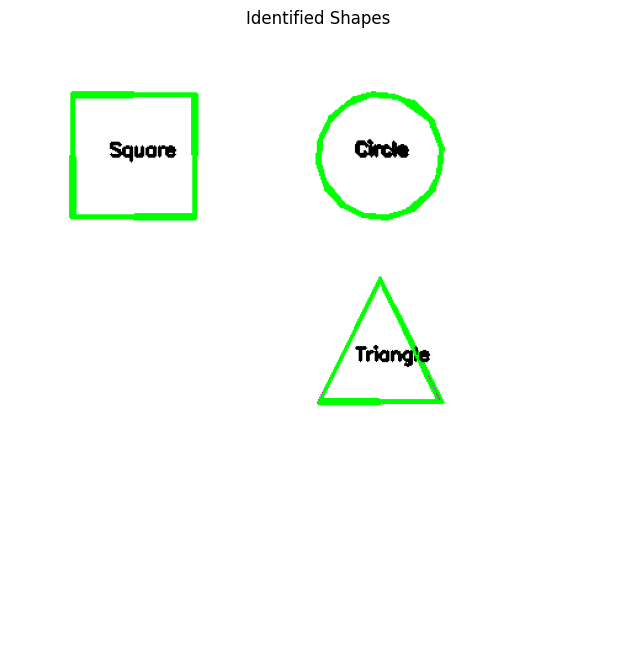

In [ ]:


#############################################
# PART 3: SHAPE RECOGNITION
#############################################

def identify_shapes(img, contours):
    img_shapes = img.copy()

    for cnt in contours:
        # Calculate area and perimeter
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)

        # Skip small contours (noise)
        if area < 100:
            continue

        # Approximate the contour shape
        epsilon = 0.01 * perimeter
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        # Get the number of vertices
        vertices = len(approx)

        # Find shape center for text placement
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Identify shape based on vertices
        if vertices == 3:
            shape_name = "Triangle"
        elif vertices == 4:
            # Check if it's a square or rectangle
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            if 0.95 <= aspect_ratio <= 1.05:
                shape_name = "Square"
            else:
                shape_name = "Rectangle"
        elif vertices == 5:
            shape_name = "Pentagon"
        elif vertices == 6:
            shape_name = "Hexagon"
        elif vertices > 10:
            # For circles, number of vertices will be high
            shape_name = "Circle"
        else:
            shape_name = f"{vertices}-gon"

        # Draw shape name
        cv2.putText(img_shapes, shape_name, (cX - 20, cY),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # Draw contour
        cv2.drawContours(img_shapes, [approx], 0, (0, 255, 0), 2)

    display_image(img_shapes, "Identified Shapes")
    return img_shapes
identified_img = identify_shapes(img, contours)

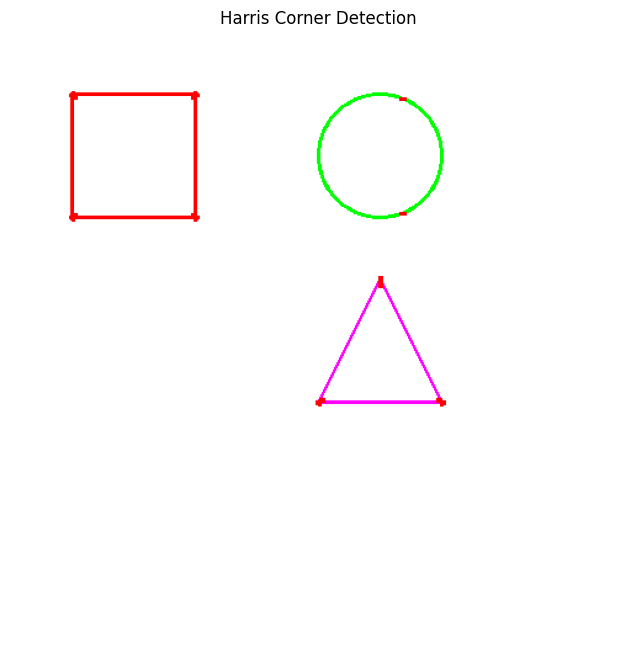

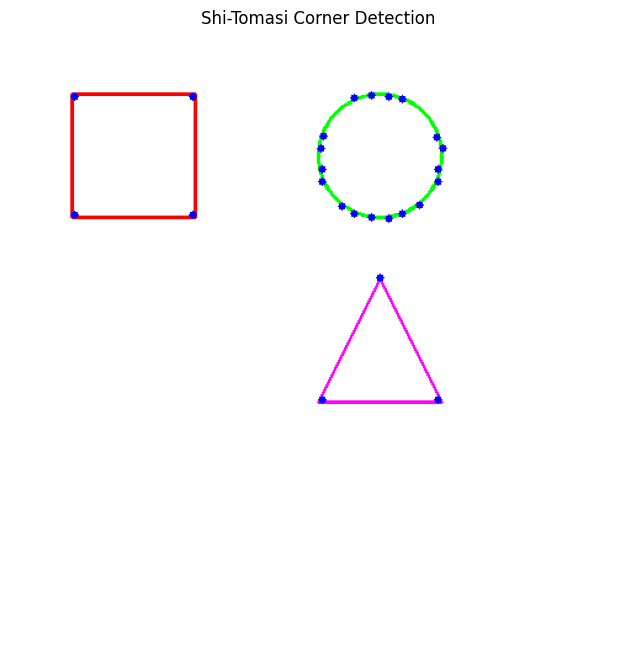

In [ ]:

#############################################
# PART 4: FEATURE EXTRACTION - CORNERS
#############################################

def detect_corners(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Harris Corner Detection
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

    # Dilate to mark the corners
    dst = cv2.dilate(dst, None)

    # Threshold for an optimal value, marking corners in red
    img_harris = img.copy()
    img_harris[dst > 0.01 * dst.max()] = [0, 0, 255]

    display_image(img_harris, "Harris Corner Detection")

    # Shi-Tomasi Corner Detection
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=25, qualityLevel=0.01, minDistance=10)
    corners = np.intp(corners)

    img_shi_tomasi = img.copy()
    for i in corners:
       x, y = i.ravel()
       cv2.circle(img_shi_tomasi, (x, y), 3, [255, 0, 0], -1)

    display_image(img_shi_tomasi, "Shi-Tomasi Corner Detection")

    return img, img_harris, img_shi_tomasi
img, harris_img, shi_tomasi_img = detect_corners(img)

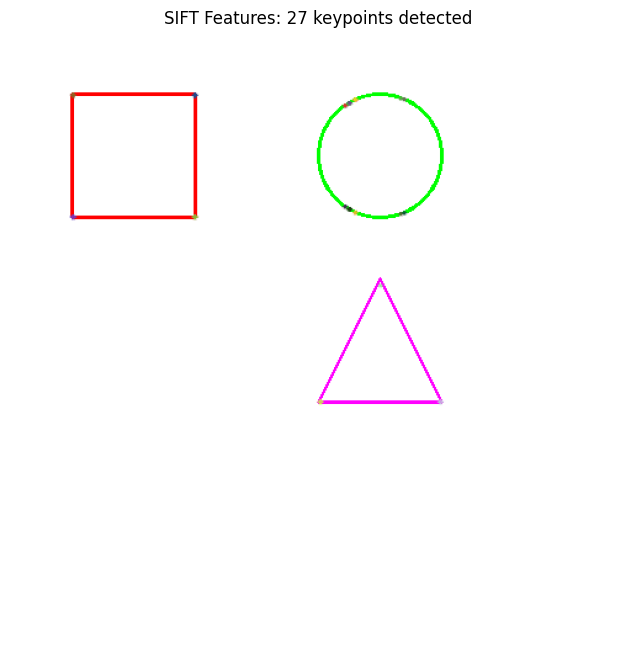

In [ ]:
#############################################
# PART 5: ADVANCED FEATURE DETECTION - SIFT
#############################################

def sift_feature_detection(img):


    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Draw keypoints
    img_sift = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    display_image(img_sift, f"SIFT Features: {len(keypoints)} keypoints detected")

    return img, img_sift, keypoints, descriptors
img, sift_img, keypoints, descriptors = sift_feature_detection(img)

In [ ]:

#############################################
# PART 6: ADVANCED FEATURE DETECTION - ORB
#############################################

def orb_feature_detection(img):


    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=50)

    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    # Draw keypoints
    img_orb = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    display_image(img_orb, f"ORB Features: {len(keypoints)} keypoints detected")

    return img, img_orb, keypoints, descriptors
img, orb_img, keypoints, descriptors = orb_feature_detection(img)


In [ ]:

#############################################
# PART 7: FEATURE MATCHING BETWEEN IMAGES
#############################################

def feature_matching(img1=None, img2=None, img1_path=None, img2_path=None):
    if img1_path and img2_path:
        # Load images
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
    elif img1 is None or img2 is None:
        # Create sample images with similar but slightly different features
        img1 = np.zeros((500, 500, 3), dtype=np.uint8)
        img1.fill(255)
        cv2.rectangle(img1, (100, 100), (300, 300), (0, 0, 255), 2)
        cv2.circle(img1, (400, 250), 80, (0, 255, 0), 2)

        img2 = np.zeros((500, 500, 3), dtype=np.uint8)
        img2.fill(255)
        cv2.rectangle(img2, (120, 120), (320, 320), (0, 0, 255), 2)
        cv2.circle(img2, (420, 270), 80, (0, 255, 0), 2)

    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector (faster than SIFT and freely available)
    orb = cv2.ORB_create()

    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # Create BFMatcher (Brute Force Matcher)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 30 matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    display_image(img_matches, "Feature Matching (Best 30 matches)")

    return img_matches, matches
matches_img, matches = feature_matching()

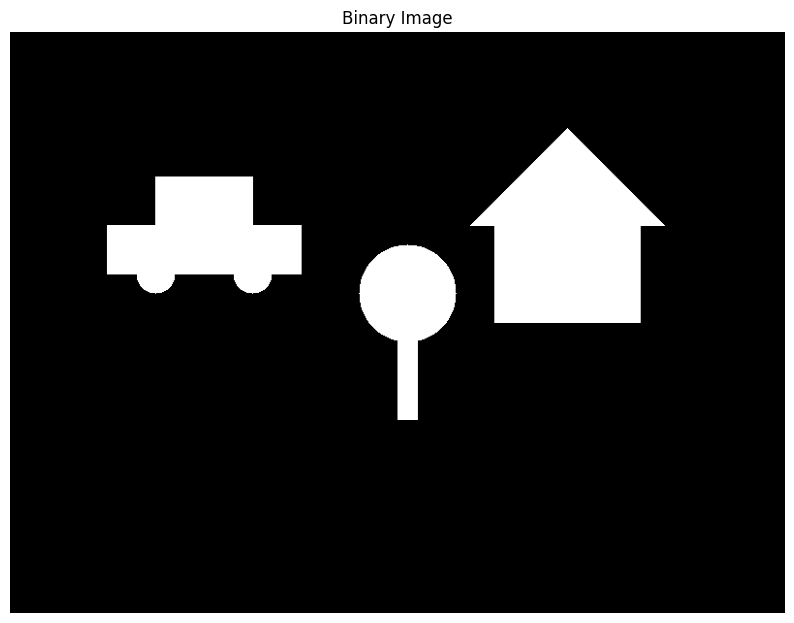

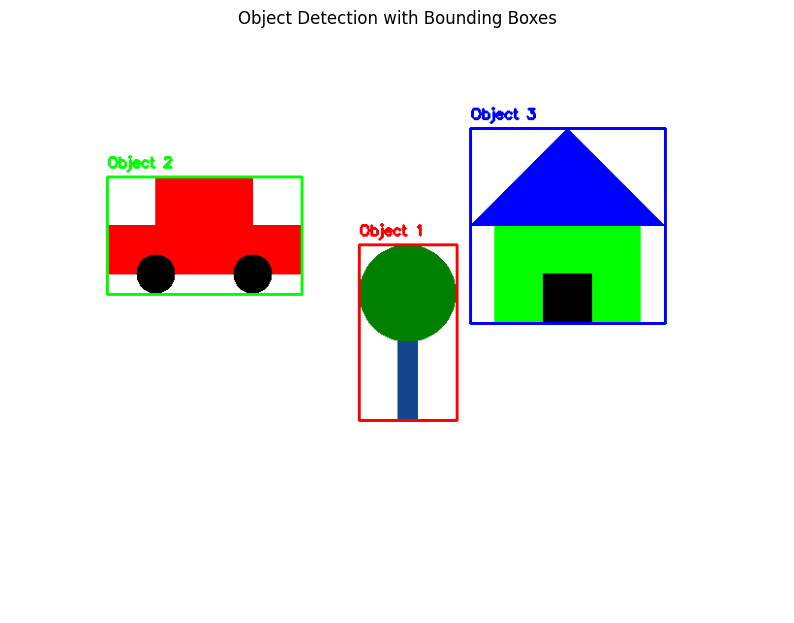

In [ ]:


def basic_object_detection(image_path=None):
    if image_path:
        # Load an image
        img = cv2.imread(image_path)
    else:
        # Create a simple image with multiple objects
        img = np.zeros((600, 800, 3), dtype=np.uint8)
        img.fill(255)

        # Draw a car-like shape
        cv2.rectangle(img, (100, 200), (300, 250), (0, 0, 255), -1)  # Car body
        cv2.rectangle(img, (150, 150), (250, 200), (0, 0, 255), -1)  # Car top
        cv2.circle(img, (150, 250), 20, (0, 0, 0), -1)  # Left wheel
        cv2.circle(img, (250, 250), 20, (0, 0, 0), -1)  # Right wheel

        # Draw a house-like shape
        cv2.rectangle(img, (500, 200), (650, 300), (0, 255, 0), -1)  # House body
        triangle_pts = np.array([[475, 200], [575, 100], [675, 200]], np.int32)
        cv2.fillPoly(img, [triangle_pts], (255, 0, 0))  # Roof
        cv2.rectangle(img, (550, 250), (600, 300), (0, 0, 0), -1)  # Door

        # Draw a tree-like shape
        cv2.rectangle(img, (400, 300), (420, 400), (139, 69, 19), -1)  # Trunk
        cv2.circle(img, (410, 270), 50, (0, 128, 0), -1)  # Foliage

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply threshold
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes for each detected object
    img_objects = img.copy()
    for idx, cnt in enumerate(contours):
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(cnt)

        # Skip very small contours (noise)
        if w * h < 500:
            continue

        # Different color for each object
        color = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0)][idx % 4]

        # Draw the bounding rectangle
        cv2.rectangle(img_objects, (x, y), (x + w, y + h), color, 2)

        # Label the object with an ID
        cv2.putText(img_objects, f"Object {idx+1}", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    display_image(binary, "Binary Image")
    display_image(img_objects, "Object Detection with Bounding Boxes")

    return img, binary, img_objects


img, binary, objects_img = basic_object_detection()


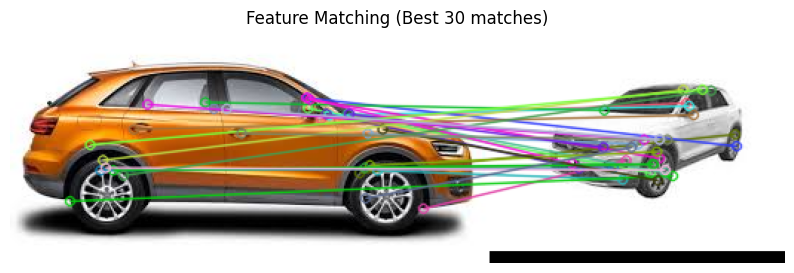

In [ ]:
#############################################
# PART 7: FEATURE MATCHING BETWEEN IMAGES
#############################################

def feature_matching(img1=None, img2=None, img1_path=None, img2_path=None):

        # Load images
    img1 = cv2.imread('/content/drive/MyDrive/pythonppts/nan/car.png')
    img2 = cv2.imread('/content/drive/MyDrive/pythonppts/nan/car2.jpeg')


    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector (faster than SIFT and freely available)
    orb = cv2.ORB_create()

    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # Create BFMatcher (Brute Force Matcher)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 30 matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    display_image(img_matches, "Feature Matching (Best 30 matches)")

    return img_matches, matches
matches_img, matches = feature_matching()

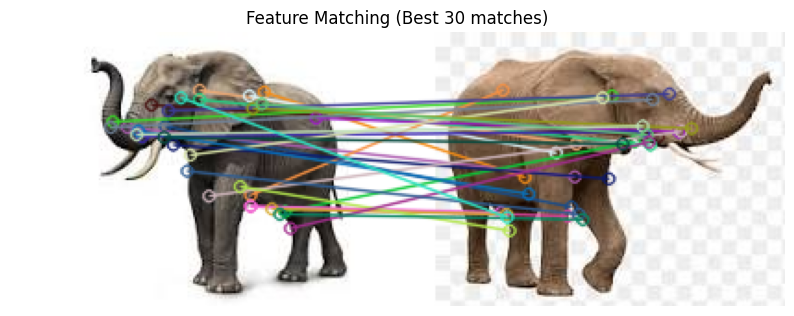

In [ ]:
#############################################
# PART 7: FEATURE MATCHING BETWEEN IMAGES
#############################################

def feature_matching(img1=None, img2=None, img1_path=None, img2_path=None):

        # Load images
    img1 = cv2.imread('/content/drive/MyDrive/pythonppts/nan/ele.jpeg')
    img2 = cv2.imread('/content/drive/MyDrive/pythonppts/nan/ele2.jpeg')


    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector (faster than SIFT and freely available)
    orb = cv2.ORB_create()

    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # Create BFMatcher (Brute Force Matcher)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 30 matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    display_image(img_matches, "Feature Matching (Best 30 matches)")

    return img_matches, matches
matches_img, matches = feature_matching()